In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from utils import optimize_e, optimize_b
import sys

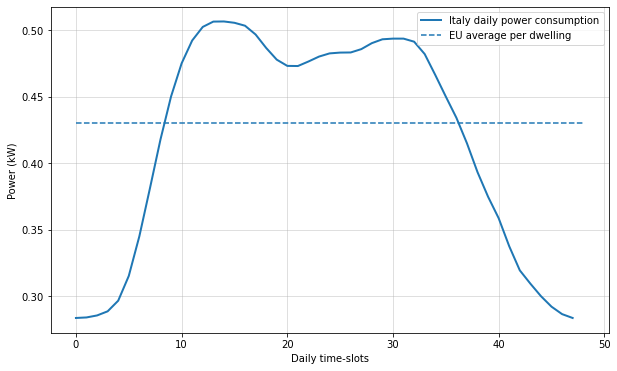

In [2]:
# Import the load profile
load_curve = np.loadtxt('data/load_agg_data.csv', delimiter=',', skiprows=1)[:, 2]
plt.figure(figsize=(10,6))
plt.plot(load_curve, lw=2, label='Italy daily power consumption')
plt.hlines(y=0.43, xmin=0, xmax=48, ls='dashed', label='EU average per dwelling')
plt.xlabel('Daily time-slots')
plt.ylabel('Power (kW)')
plt.grid(alpha=0.5)
plt.legend()

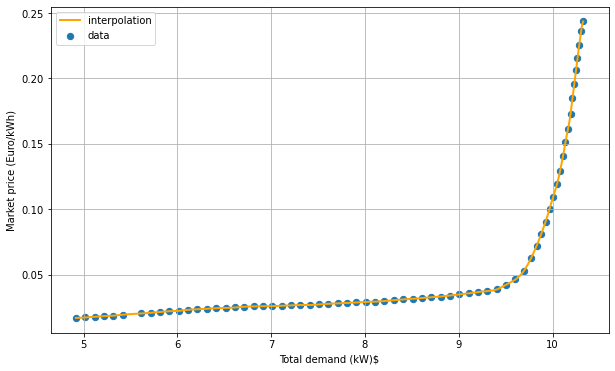

In [3]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 2.6 -1

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 600)
plt.figure(figsize=(10,6))
plt.scatter(tot_demand, market_price_data[:, 1] / 1000, s=40, label='data')
plt.plot(x, market_price(x), lw=2, label='interpolation', c='orange')
plt.xlabel(r'Total demand (kW)$')
plt.ylabel('Market price (Euro/kWh)')
plt.legend()
plt.grid()

Italy average consumption per-capita in 1 year: $4750~kWh$

$\Rightarrow 0.55~kW \rightarrow \times 60 \text{ millions} \rightarrow 3.3 \cdot 10^4~ MW$

# Grid simulation

## Consumer's parameters

- EU per-dwelling consumption 3.7 MWh $\rightarrow$ 0.43 kW

In [4]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 10                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

## Simulation

In [129]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history

In [130]:
# Customer's utility function: for optimizing wrt b_pm
def u_b(b_pm, p, l, c, e):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    e: storage capacity 
    """
    return np.sum(p * (b_pm[:T] - b_pm[T:] + l)) + c*e


# Customer's utility function: for optimizing wrt e
def u_e(e, b_pm, p, l, c):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    e: storage capacity 
    """
    return np.sum(p * (b_pm[:T] - b_pm[T:] + l)) + c*e

First step

In [131]:
# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))

Text(0.5, 1.0, 'price profile')

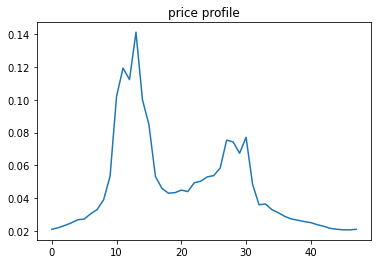

In [132]:
plt.plot(p)
plt.title('price profile')

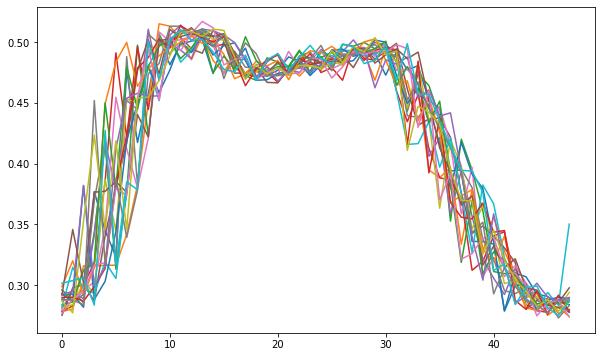

In [133]:
plt.figure(figsize=(10,6))
for i in range(n_nodes):
    plt.plot(l[i,:])

First I optimize $u(b, p, l, c, e)$ wrt $e$

In [134]:
# generate constraint
constr_ev = np.zeros(T)
for i in range(T):
    constr_ev[i] = b_pm[0, i] + e0[0] + np.sum(b_pm[0, :i] - b_pm[0, T : T+i])

constr_e = np.max(constr_ev)

from scipy.optimize import minimize_scalar
e_opt = minimize_scalar(u_e, args=(b_pm[0, :], p, l[0, :], c[0]),
    method='Bounded',
    bounds=(constr_e, 5.))

Update the storage capacity 

In [135]:
e[0] = e[0] + beta_1*(e_opt.x - e[0])

Maximize wrt b

In [136]:
# Generate the constraint matrix

# storage efficiency
mat1 = np.zeros(shape=(1, 2*T), dtype='float')
for j in range(T):
    mat1[0, j] = -alpha
    mat1[0, j+T] = 1

# within charging and discharging capacity
mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

# energy that can be stored or used at a time slot
mat4 = np.zeros(shape=(T, 2*T), dtype='float')
mat4[0, T] = 1
for i in range(1, T):
    for j in range(i):
        mat4[i, j] = -alpha
        mat4[i, j+T] = alpha
    mat4[i-1, i-1+T] = 1

mat5 = np.zeros(shape=(T, 2*T), dtype='float')
mat5[0, 0] = 1
for i in range(1, T):
    for j in range(i):
        mat5[i, j] = 1
        mat5[i, j+T] = -1
    mat5[i-1, i-1] = 1    

mat_constr = np.vstack([mat1, mat2, mat3, mat4, mat5, mat3])

In [137]:
# generate constraint vectors

# left
leftv_constr = - np.ones(241) * np.inf
leftv_constr[0] = 0

# right
rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [alpha * e0[0]] * T, [e[0] - e0[0]] * T, l[0, :]])

In [138]:
from scipy.optimize import Bounds, LinearConstraint
linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
x0 = np.zeros(2 * T)
#x0 = np.abs(np.random.randn(2*T))
b_opt = minimize(u_b, x0, args=(p, l[0, :], c[0], e[0]), method='trust-constr',
    constraints=linear_constraint,
    bounds=bounds,
    options={'verbose' : 0})

Update the storage profile

In [139]:
b_pm[0, :] = b_pm[0, :] + beta_2 * (b_opt.x - b_pm[0, :]) 

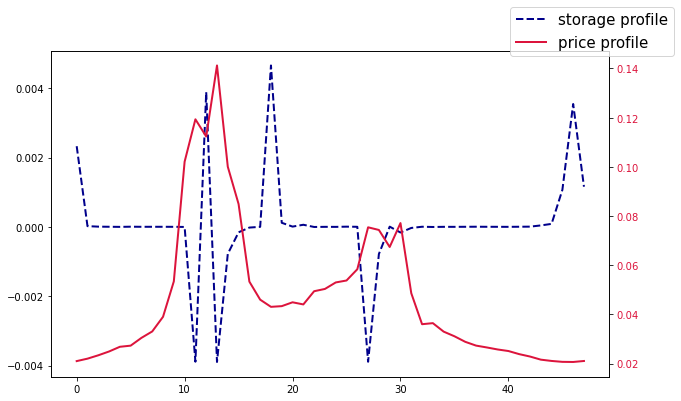

In [140]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(b_pm[0, :T] - b_pm[0, T:], label='storage profile', lw=2, ls='dashed', c='darkblue')
ax2 = ax1.twinx()
ax2.plot(p, label='price profile', lw=2, c='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
fig.legend(fontsize=15)

In [142]:
np.sum(b_pm[0, :T] - b_pm[0, T:])

0.003438437911416068

Now I do it for all players

In [143]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))

In [144]:
profiles = np.ndarray((n_nodes, T))
for n in range(n_nodes):
    # optimize e
    e_opt = optimize_e(n, b_pm, p, l, c, e0)
    # update e
    e[n] = e[n] + beta_1*(e_opt - e[n])
    # optimize b
    b_opt = optimize_b(n, b_sup, b_inf, p, c, alpha, e0, e, l)
    # update b
    b_pm[n, :] = b_pm[n, :] + beta_2 * (b_opt - b_pm[n, :])
    profiles[n, :] = b_pm[n, :T] - b_pm[n, T:]
    print(f'completed node {n+1}/{n_nodes}')

completed node 1/20
completed node 2/20
completed node 3/20
completed node 4/20
completed node 5/20
completed node 6/20
completed node 7/20
completed node 8/20
completed node 9/20
completed node 10/20
completed node 11/20
completed node 12/20
completed node 13/20
completed node 14/20
completed node 15/20
completed node 16/20
completed node 17/20
completed node 18/20
completed node 19/20
completed node 20/20


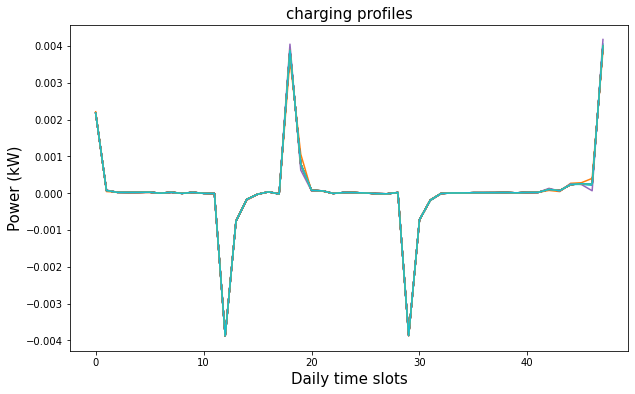

In [145]:
plt.figure(figsize=(10,6))
plt.xlabel('Daily time slots', size=15)
plt.ylabel('Power (kW)', size=15)
plt.title('charging profiles', size=15)
for profile in profiles:
    plt.plot(profile)

### Complete simulation

In [81]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 10                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

In [89]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history
e_history = np.array([])                # total storage

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
e_history = np.append(e_history, e.sum())

In [90]:
for d in range(n_days):
    profiles = np.ndarray((n_nodes, T))
    for n in range(n_nodes):
        # optimize e
        e_opt = optimize_e(n, b_pm, p, l, c, e0)
        # update e
        e[n] = e[n] + beta_1*(e_opt - e[n])
        # optimize b
        b_opt = optimize_b(n, b_sup, b_inf, p, c, alpha, e0, e, l)
        # update b
        b_pm[n, :] = b_pm[n, :] + beta_2 * (b_opt - b_pm[n, :])
        # update e0
        e0[n] = e0[n] + b_pm[n, :T].sum() - b_pm[n, T:].sum()
        
        profiles[n, :] = b_pm[n, :T] - b_pm[n, T:]
        print(f'completed node {n+1}/{n_nodes} of day {d+1}/{n_days}', end='\r')
        sys.stdout.flush()
    b_history = np.append(b_history, [np.mean(profiles, axis=0)], axis=0)
    p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
    p_history = np.append(p_history, [p], axis=0)
    e_history = np.append(e_history, e.sum())

/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


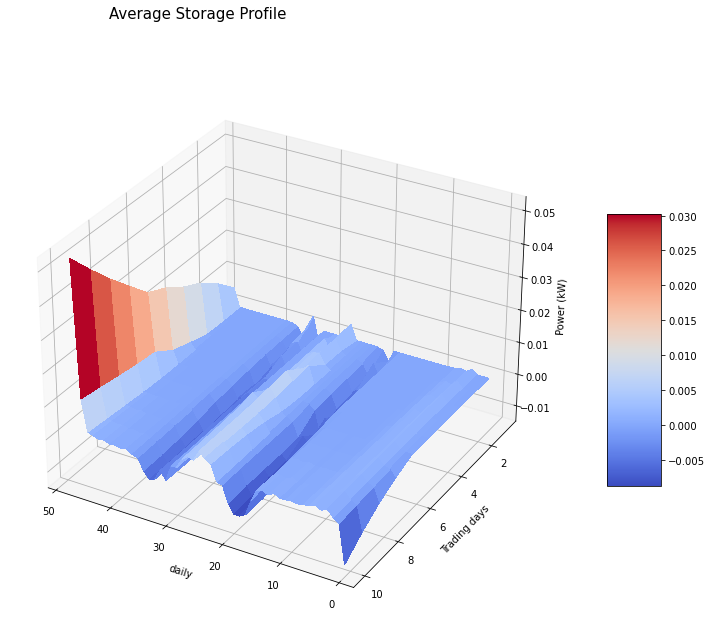

In [92]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Power (kW)', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Average Storage Profile', size=15);

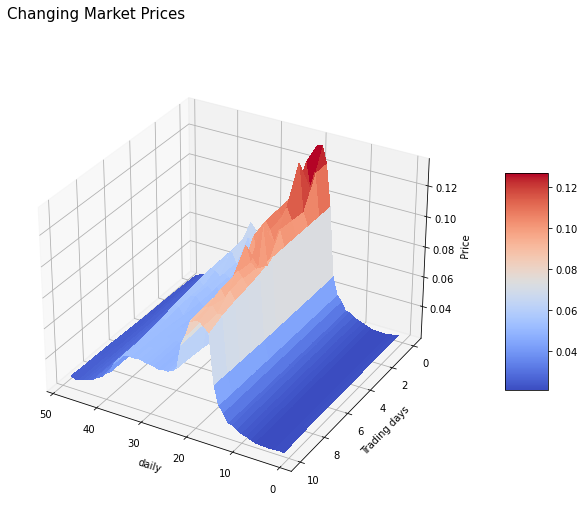

In [93]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,8))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Price', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Changing Market Prices', size=15);

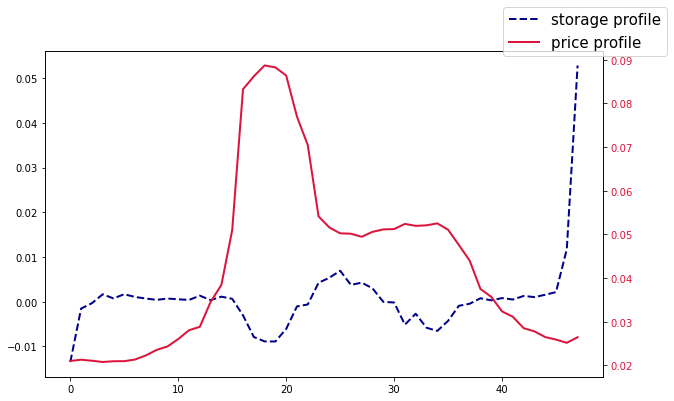

In [94]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(b_history[-1], label='storage profile', lw=2, ls='dashed', c='darkblue')
ax2 = ax1.twinx()
ax2.plot(p_history[-1], label='price profile', lw=2, c='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
fig.legend(fontsize=15)

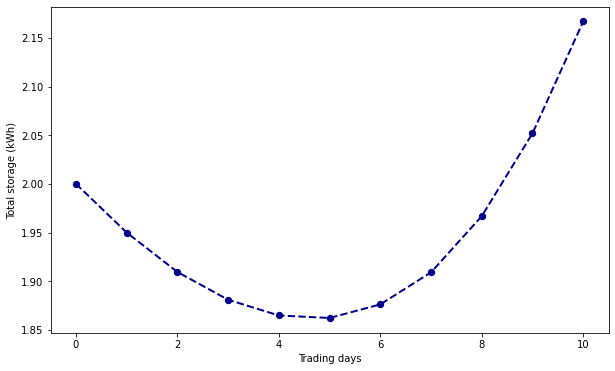

In [95]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(e_history, lw=2, ls='dashed', c='darkblue')
ax1.scatter(np.arange(len(e_history)), e_history, s=40, c='darkblue')
ax1.set_xlabel('Trading days')
ax1.set_ylabel('Total storage (kWh)');

### Parallelize

In [18]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 5                                 # number of days to simulate 
beta_1 = 0.05                               # storage capacity learning rate
beta_2 = 0.05                               # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency
c = np.random.rand(n_nodes)*0.05            # running cost of using storage (Euro/kWh)

In [19]:
# Intialization
e0 = np.ones(n_nodes)*0.05              # storage level
e = np.ones(n_nodes)*0.1                # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history
e_history = np.array([])                # total storage

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
e_history = np.append(e_history, e.sum())

In [20]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
e_opt_dict = {}
b_opt_dict = {}
for d in range(n_days):
    profiles = np.ndarray((n_nodes, T))

    # optimize e
    for n in range(n_nodes):
        e_opt_dict[n] = pool.apply_async(optimize_e, args=(n, b_pm, p, l, c, e0))
    e_opt = np.array([e_opt_dict[n].get(timeout=180) for n in range(n_nodes)])

    # update e
    e = e + beta_1*(e_opt - e)

    # optimize b
    for n in range(n_nodes):
        b_opt_dict[n] = pool.apply_async(optimize_b, args=(n, b_sup, b_inf, p, c, alpha, e0, e, l))
    b_opt = np.array([b_opt_dict[n].get(timeout=180) for n in range(n_nodes)])

    # update b
    b_pm = b_pm + beta_2 * (b_opt - b_pm)

    # update e0
    e0 = e0 + b_pm[:, :T].sum() - b_pm[:, T:].sum()

    b_history = np.append(b_history, [np.mean(b_pm[:, :T] - b_pm[:, T:], axis=0)], axis=0)
    p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
    p_history = np.append(p_history, [p], axis=0)
    e_history = np.append(e_history, e.sum())
    print(f'completed day {d+1}/{n_days}')
pool.close()

completed day 1/5


/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lorenzo/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
 

KeyboardInterrupt: 

Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-19:
  File "/home/lorenzo/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/lorenzo/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lorenzo/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/lorenzo/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lorenzo/anaconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/lorenzo/Desktop/Game Theory/Project/Smart-Grids-GT/utils.py", line 100, in optimize_b
    b_opt = minimize(u_b, x0, args=(p, l[n, :], c[n], e[n]), method='trust-constr',
  File "/home/lorenzo/anacon

In [9]:
a = {0:'a', 2 : 'c', 1 : 'b'}
b = [a[n] for n in range(3)]

In [11]:
np.array([[1,2,3],[4,5,6]])

array([[1, 2, 3],
       [4, 5, 6]])